# Simulation 3
See README.md for a short description.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d

import constants as const
import server as srv
import agent as agn

In this implementation all the parameters of the game are defined in the *const.py* script. A *Server* has 4 ports, 5 potential vulnerable webservices it may be running, 4 potential vulnerable parameter it may receive at 2 different levels of depth.

This implies 45 possible concrete actions for the attacker.

Setting a random seed

In [2]:
np.random.seed(0)

### Random server
We define a simple function to instantiate random servers.

In [3]:
def random_server():
    vulnport = np.random.randint(0,const.N_PORTS)
    vulntype = np.random.choice(const.VULNTYPES)
    
    if(vulntype==const.VULNTYPE_ACCESSPOINT):
        vulnlevel = const.VULNLEVEL_NONE
        n = np.argmax(np.random.multinomial(1,[.5,.3,.1,.05,.05]))+1
        vulnvalue = np.random.choice(const.ACCESSPOINTS,n,replace=False)
    elif(vulntype==const.VULNTYPE_PARAM):
        vulnlevel = np.random.choice(const.VULNLEVELS)
        vulnvalue = np.random.randint(1,const.N_VULNPARAMS+1)
        
    return srv.Server(vulnport, vulnlevel, vulntype, vulnvalue)

### Creating the agent and setting the learning options 

In [4]:
agt = agn.Agent()
agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

## Simulation 3.1

We run a little number of episodes ($10$) just to observe the dynamics of the game.

In [5]:
nepisodes = 10
for _ in range(nepisodes):
    
    env = random_server()
    agt.reset(env)
    
    agt.run_episode()


HACKER: Resetting...
SERVER: Server reset
HACKER: Trying to take over process Process_PID_3435 on port http:80...
SERVER: Access Attempt Failed
HACKER: Trying to execute exploit with param 2 on port http:80...
SERVER: Param Exploit Failed
HACKER: Trying to execute exploit with param 2 on port http:80...
SERVER: Param Exploit Failed
HACKER: Trying to execute exploit with param 2 on port http:80...
SERVER: Param Exploit Failed
HACKER: Trying to execute exploit with param 2 on port http:80...
SERVER: Param Exploit Failed
HACKER: Trying to execute exploit with param 2 on port http:80...
SERVER: Param Exploit Failed
HACKER: Trying to execute exploit with param 2 on port http:80...
SERVER: Param Exploit Failed
HACKER: Trying to execute exploit with param 2 on port http:80...
SERVER: Param Exploit Failed
HACKER: Trying to take over process Process_PID_8 on port http:80...
SERVER: Access Attempt Failed
HACKER: Trying to execute exploit with param 3 on port ftp:20...
SERVER: Param Exploit Fail

## Simulation 3.2
Given the large space of states and actions we need to run a large number of episodes in order to start learning a sensible policy. 

**(Notice that this may take some minutes to run)**

**(Notice we reiniatialized the agent not to be verbose)**

In [6]:
agt = agn.Agent(verbose=False)
agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

In [7]:
steps = []
rewards = []
Qlens = []

nepisodes = 10**6
for _ in tqdm(range(nepisodes)):
    
    env = random_server()
    agt.reset(env)
    
    agt.run_episode()
    #print(len(agt.Q.keys()))
    
    steps.append(agt.steps)
    rewards.append(agt.rewards)
    Qlens.append(len(agt.Q))

100%|███████████████████████████████| 1000000/1000000 [02:44<00:00, 6061.21it/s]


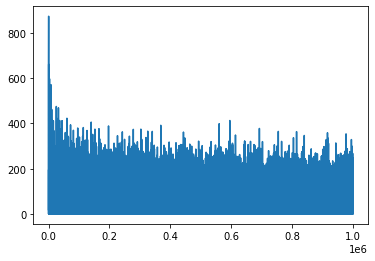

In [8]:
plt.plot(np.arange(nepisodes),steps)

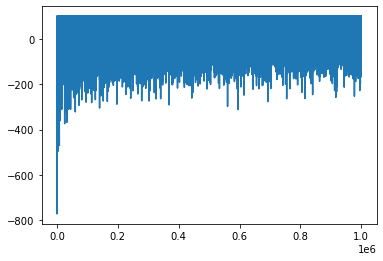

In [9]:
plt.plot(np.arange(nepisodes),rewards)

Learning takes a long time, but we notice indeed that the number of steps decrease while the amount of reward increase.

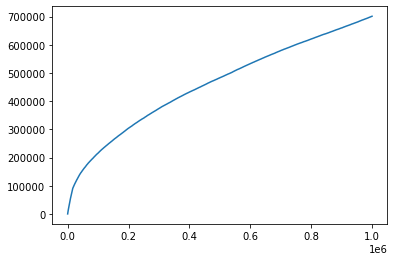

In [10]:
plt.plot(np.arange(nepisodes),Qlens)

We also observe a constant increase in the size of the Q-table (which grows exponentially at the beginning and slows down later). As new states are encountered during learning and exploration, new states are added to the Q-table. This game setting already shows the limitation of a Q-tabular approach, both in the sense of *space requirements* and in the sense of *lack of generalization*.

Yet, notice that the agent is indeed learning: if we consider the state *s1* where the agent has learned that all ports are closed except port *http:80* (port number 0) where there the service *NodeJS* (service number 2), then by far the best action is *ACCESS NodeJS on http:80* (action number 11).

In [11]:
s1 = np.zeros((const.N_PORTS, 1+const.N_ACCESSPOINTS+1),dtype='int')
s1[:,0] = const.PORT_STATE_CLOSED
s1[0,0] = const.PORT_STATE_OPEN
s1[0,3] = const.ACCESSPOINTSTATE_OPEN
agt.Q[s1.tobytes()]

array([4.24279526, 2.08625741, 3.23984041, 6.35310225, 0.83642626,
       0.76281903, 0.9386924 , 8.16544794, 7.46358275, 2.57868412,
       2.52936059, 1.3853222 , 4.02232789, 2.08230267, 2.27367646,
       1.16132979, 7.06290107, 6.74919579, 1.24641588, 1.22462212,
       1.72577657, 2.73329205, 1.87601023, 6.44182595, 2.94749877,
       2.54527827, 3.22916663, 5.22224128, 6.46067072, 1.80122904,
       4.32741673, 0.89289468, 2.27381437, 4.19885675, 1.83341007,
       0.89938437, 5.02275256, 9.31741594, 2.42988086, 4.15232562,
       2.58327172, 2.82909334, 1.52538935, 4.79554397, 3.24780408])

In [12]:
np.argmax(agt.Q[s1.tobytes()])

37

While final actions to exploit a discovered vulnerability are clear as shown above, the agent it is still far from having a clear consistent overall strategy as the Q-values for the initial state shows. At this very early point the agent has not yet learned to distinguish actions that can lead to a more rewarding course of action.

In [13]:
s1 = np.zeros((const.N_PORTS, 1+const.N_ACCESSPOINTS+1),dtype='int')
agt.Q[s1.tobytes()]

array([234.86405728, 452.85978961, 688.72552006, 515.20231446,
       352.13178923, 414.45027197, 536.75278989, 447.8972963 ,
       375.14123227, 358.24073116, 406.34620368, 405.74197734,
       318.87408099, 387.31512159, 459.73526222, 480.46668268,
       426.8158651 , 446.53412414, 437.20569038, 374.1633063 ,
       446.39935334, 425.65113292, 397.06221079, 398.6576917 ,
       355.68601273, 356.63525751, 385.96504226, 327.82998271,
       390.37650068, 524.29886483, 523.73505124, 539.93883642,
       531.42655192, 533.16821177, 535.49501987, 525.13731235,
       534.06275871, 538.46668403, 533.96843937, 546.84797719,
       540.32856987, 541.13083546, 537.54869584, 522.09238131,
       528.15410994])

## Simulation 3.3
We run the previous simulation for $20$ times in order to collect stable statistics.

**(Notice that this may take MANY minutes to run)**

In [14]:
ntrials = 20
nepisodes = 10**5

steps = np.zeros((ntrials,nepisodes))
rewards = np.zeros((ntrials,nepisodes))
Qlens = np.zeros((ntrials,nepisodes))

for t in tqdm(range(ntrials)):
    
    agt = agn.Agent(verbose=False)
    agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

    for e in range(nepisodes):
        env = random_server()
        agt.reset(env)

        agt.run_episode()

        steps[t,e] = agt.steps
        rewards[t,e] = agt.rewards
        Qlens[t,e] = len(agt.Q)
    

100%|███████████████████████████████████████████| 20/20 [13:11<00:00, 39.58s/it]


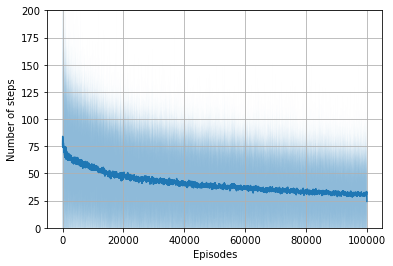

In [15]:
x = np.arange(nepisodes)
y = np.mean(uniform_filter1d(steps,size=100,mode='nearest'),axis=0)
ystd = np.std(steps,axis=0)

plt.plot(x,y)
plt.fill_between(x,y-ystd,y+ystd,alpha=.5)

plt.ylim(0,200)
plt.xlabel('Episodes')
plt.ylabel('Number of steps')
plt.grid()
plt.savefig('simul3_steps.png',dpi=300)

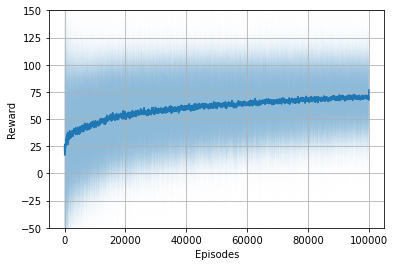

In [16]:
x = np.arange(nepisodes)
y = np.mean(uniform_filter1d(rewards,size=100,mode='nearest'),axis=0)
ystd = np.std(rewards,axis=0)

plt.plot(x,y)
plt.fill_between(x,y-ystd,y+ystd,alpha=.5)

plt.ylim(-50,150)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.grid()
plt.savefig('simul3_rewards.png',dpi=300)

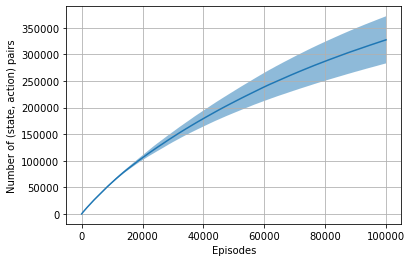

In [17]:
x = np.arange(nepisodes)
y = np.mean(Qlens,axis=0); ystd = np.std(Qlens,axis=0)
plt.plot(x,y)
plt.fill_between(x,y-ystd,y+ystd,alpha=.5)
plt.xlabel('Episodes')
plt.ylabel('Number of (state, action) pairs')
plt.grid()
plt.savefig('simul3_qlens.png',dpi=300)